In [1]:
import random
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg19, resnet18, efficientnet_b0

In [2]:
random.seed(28)
np.random.seed(28)
torch.manual_seed(28)
torch.cuda.manual_seed(28)
torch.backends.cudnn.determenistic = True

In [3]:
class SmallObjectClassificator(Dataset):
    def __init__(self, path, transform=None):
        pass

    def __len__(self):
        pass

    def __getitem__(self, index):
        pass

In [4]:
# path_to_dataset = Path('images')
# path_to_dataset

In [5]:
# train_data = path_to_dataset / 'train'
# test_data = path_to_dataset / 'test'

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # From PIL to torch.Tensor format
])

### ImageFolder отлично подходит для задач классификации изображений

In [7]:
train_data = torchvision.datasets.ImageFolder(root='images/train', transform=transform)
train_data

Dataset ImageFolder
    Number of datapoints: 1144
    Root location: images/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [8]:
test_data = torchvision.datasets.ImageFolder(root='images/test', transform=transform)
test_data

Dataset ImageFolder
    Number of datapoints: 350
    Root location: images/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

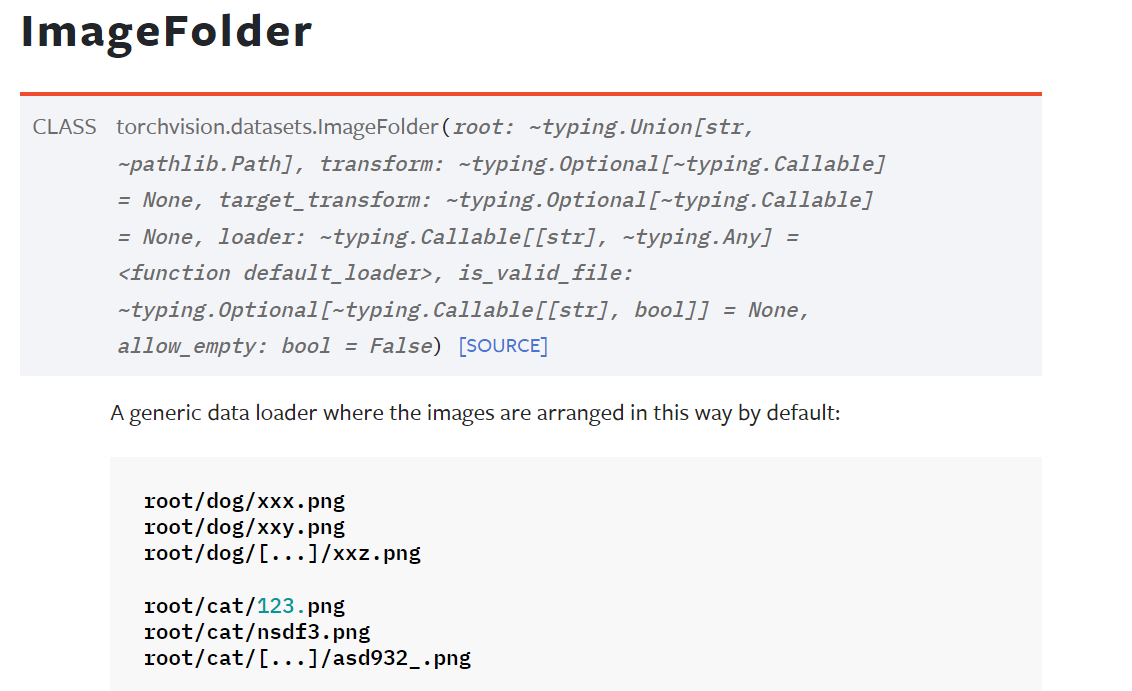

In [9]:
BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
train_dataloader

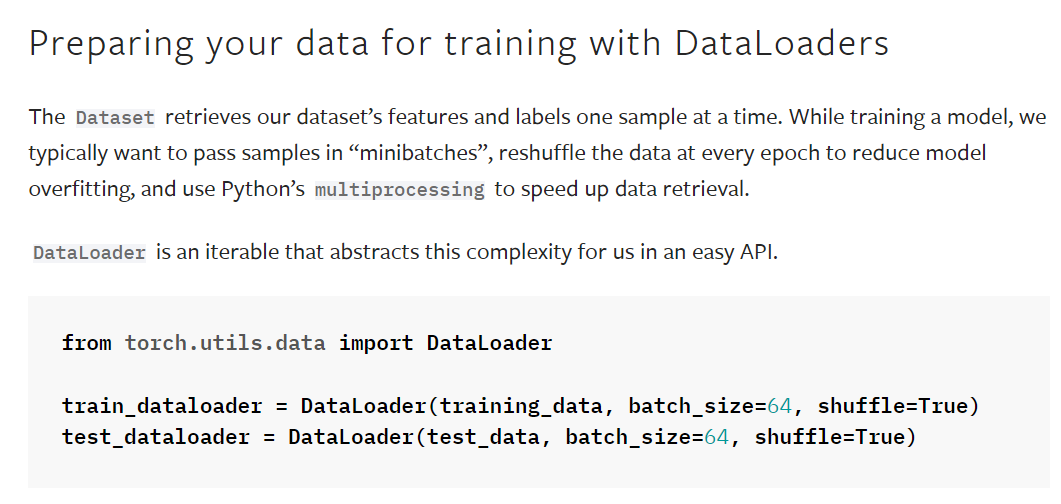

### Готовые куски кода других ML инженеров

In [11]:
# определим функцию, которая будет вычислять точность модели на итерации
def calculate_accuracy(y_pred, y):

    # находим количество верных совпадений лейбла и выходного класса по каждому примеру в батче
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()

    # посчитаем точность, которая равна отношению количества верных совпадений к общему числу примеров в батче
    acc = correct.float() / y.shape[0]
    return acc

In [12]:
def train(model, dataloader, optimizer, loss_function, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc="Training", leave=False)  # Добавляем tqdm
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Обновляем описание tqdm
        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    return running_loss / len(dataloader), correct / total

In [13]:
def evaluate(model, dataloader, loss_function, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc="Evaluating", leave=False)  # Добавляем tqdm
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Обновляем описание tqdm
            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    return running_loss / len(dataloader), correct / total

In [14]:
# def epoch_time(start_time, end_time):
#     elapsed_time = end_time - start_time
#     elapsed_mins = int(elapsed_time / 60)
#     elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
#     return elapsed_mins, elapsed_secs

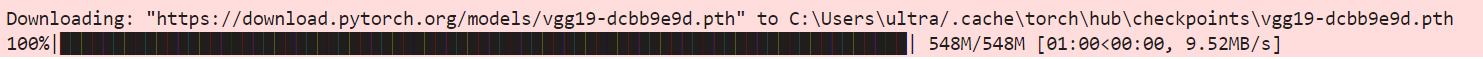

In [15]:
model = vgg19(weights='VGG19_Weights.DEFAULT')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

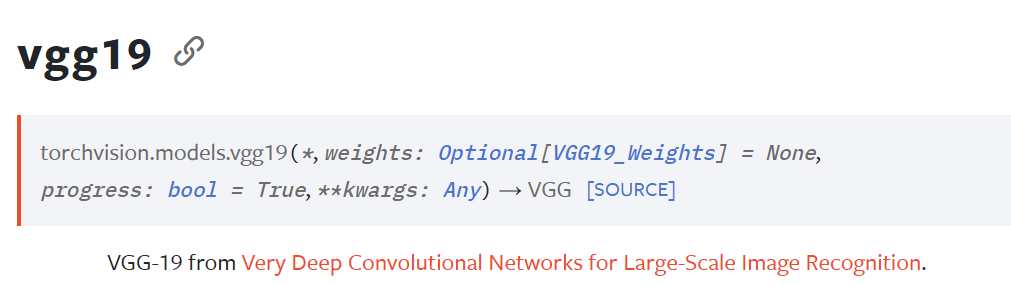

In [16]:
# определим функцию оптимизации
optimizer = optim.Adam(model.parameters(), lr=0.001)

# определим функцию потерь
loss_function = nn.CrossEntropyLoss()

# определим устройство, на котором будет идти обучение
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# перемещение модели на устройство
model.to(device)
print(device)

cpu


### Обучение VGG19

In [17]:
# from tqdm import tqdm

# epochs = 5
# best_loss = float("inf")  # Начальное значение

# for epoch in range(epochs):
#     # Обучение
#     train_loss, train_acc = train(model, train_dataloader, optimizer, loss_function, device)

#     # Оценка на валидационной выборке
#     test_loss, test_acc = evaluate(model, test_dataloader, loss_function, device)

#     # Вывод результатов
#     print(f'Epoch: {epoch+1:02}')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
#     print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc * 100:.2f}%')

#     # Сохранение лучшей модели
#     if test_loss < best_loss:
#         best_loss = test_loss
#         torch.save(model.state_dict(), "VGG19_best_loss.pth")

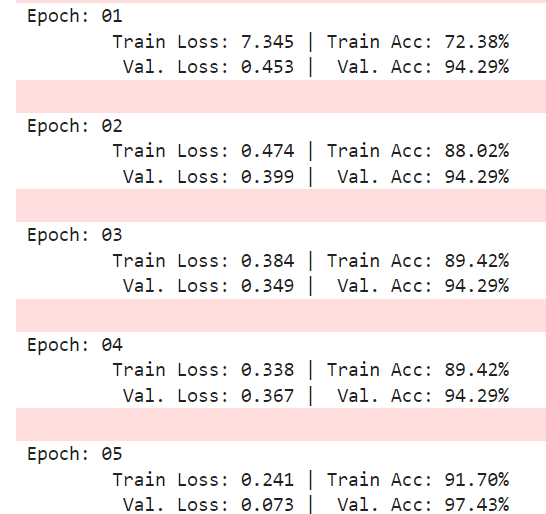

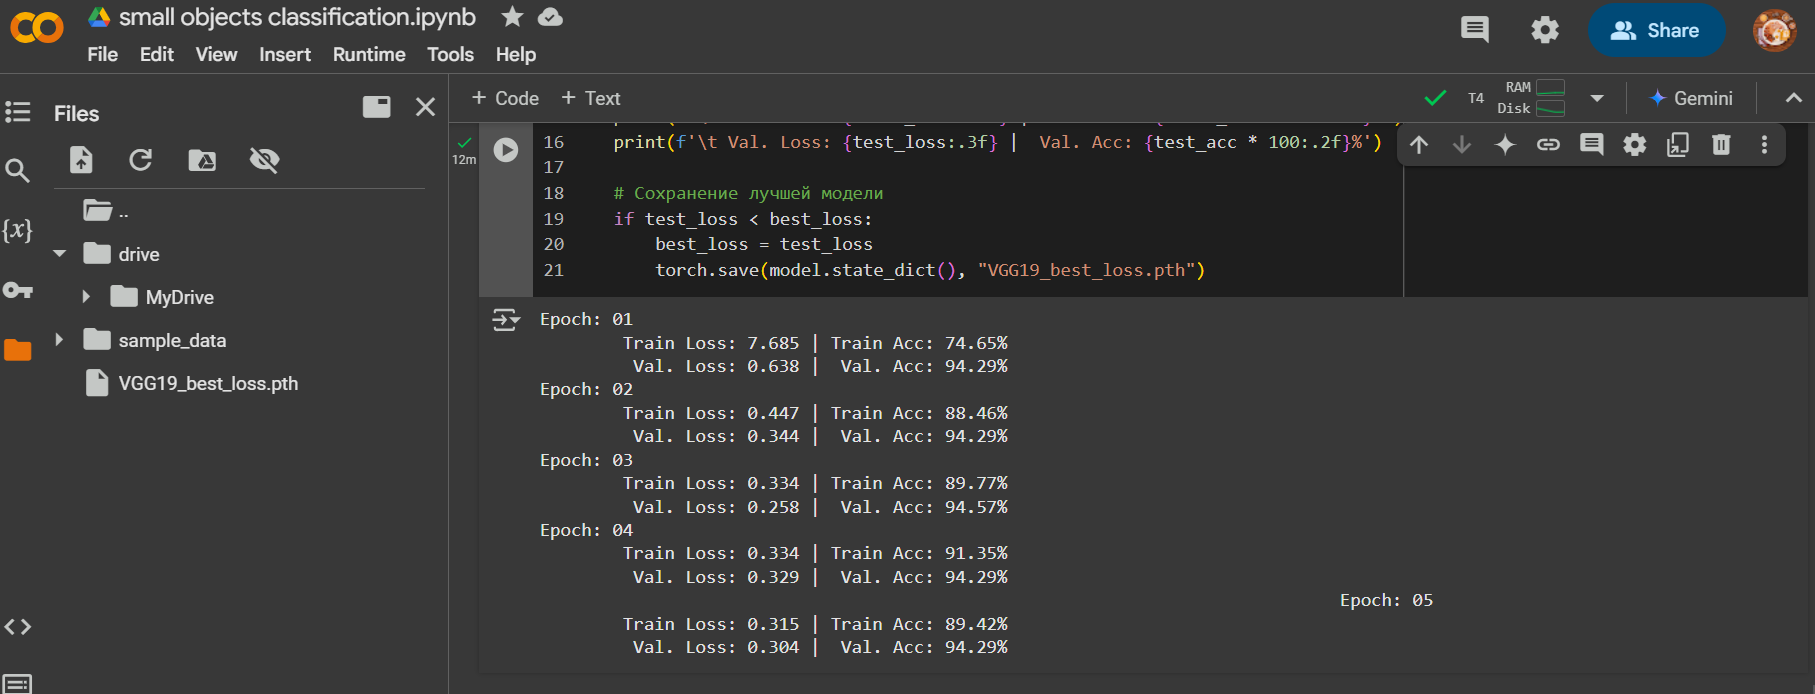

In [18]:
model2 = resnet18(weights='ResNet18_Weights.DEFAULT')
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# model2.to(device)
# optimizer = optim.Adam(model2.parameters(), lr=0.001)

# epochs = 5
# best_loss = float("inf")  # Начальное значение

# for epoch in range(epochs):
#     # Обучение
#     train_loss, train_acc = train(model2, train_dataloader, optimizer, loss_function, device)

#     # Оценка на валидационной выборке
#     test_loss, test_acc = evaluate(model2, test_dataloader, loss_function, device)

#     # Вывод результатов
#     print(f'Epoch: {epoch+1:02}')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
#     print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc * 100:.2f}%')

#     # Сохранение лучшей модели
#     if test_loss < best_loss:
#         best_loss = test_loss
#         torch.save(model2.state_dict(), "ResNet18_best_loss.pth")

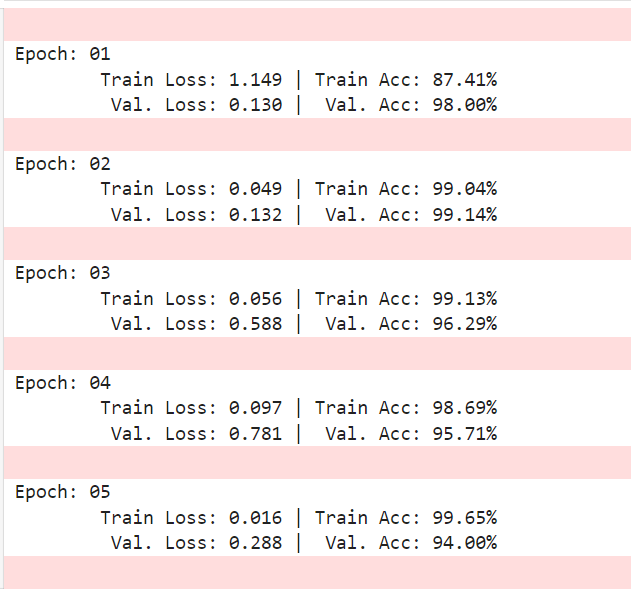

In [20]:
model3 = efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
model3

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [21]:
# model3.to(device)
# optimizer = optim.Adam(model3.parameters(), lr=0.001)

# epochs = 5
# best_loss = float("inf")  # Начальное значение

# for epoch in range(epochs):
#     # Обучение
#     train_loss, train_acc = train(model3, train_dataloader, optimizer, loss_function, device)

#     # Оценка на валидационной выборке
#     test_loss, test_acc = evaluate(model3, test_dataloader, loss_function, device)

#     # Вывод результатов
#     print(f'Epoch: {epoch+1:02}')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
#     print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc * 100:.2f}%')

#     # Сохранение лучшей модели
#     if test_loss < best_loss:
#         best_loss = test_loss
#         torch.save(model3.state_dict(), "EfficientNet_B0_loss.pth")

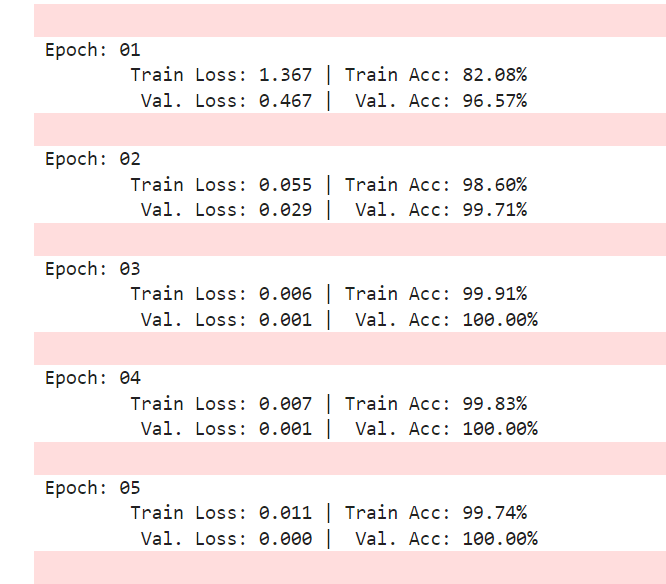